## Holm, et al - Individual Gene Analysis of RNASeq Data
### Aged Bone Marrow (normal control) vs. Myeloproliferative Neoplasms (MPN) 
### Genes
* CDK13
* SUMF2

In [1]:
library(IRdisplay)
library(limma)
library(edgeR)
library(Glimma)
#library(Mus.musculus)
library(Homo.sapiens)
library(splitstackshape)
library(PoiClaClu)
library(statmod)
library(plyr)
library(dplyr)
library(gdata)
library(org.Hs.eg.db)
library(ggplot2)
library(plyr)
library(ggpubr)
EG2SYM <- toTable(org.Hs.egSYMBOL)
ENS2EG <- toTable(org.Hs.egENSEMBL2EG)
ENS2EG2SYM <- data.frame(gene_id=ENS2EG$gene_id, ens_id=ENS2EG, 
                         SYM=EG2SYM[match(ENS2EG$gene_id,EG2SYM$gene_id),"symbol"])

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which

### Preprocess RNASeq Count Data and metadata

In [2]:
name <- "comp2"
name2 <- "20180216"
genes_rsem_new <- read.csv("all_genes_results.txt", sep="\t", stringsAsFactors=FALSE)
dim(genes_rsem_new)
gene_counts_new <- genes_rsem_new[,sapply(colnames(genes_rsem_new), function(x) any(grepl(".results_expected_count",x)))]
colnames(gene_counts_new) <- gsub(".genes.results_expected_count","", colnames(gene_counts_new))
row.names(gene_counts_new) <- genes_rsem_new$gene_id
head(gene_counts_new)
    

[1] 57820   734

,X4259_GTGAAA_S0,X87,X97,X4727sp1,X22_15,X4215_GTGAAA_S0,X26_2,X4066_GTGAAA_S0,X91,X426_ACAGTG_S0,⋯,X670A.PB.Prog_S3,X664.Stroma_S6,X767_Stroma_S0,X600.PB.Prog_S0,X689.BM.Prog_S11,X666.PB.Stem_S3,X571.Stroma_S0,X672A.PB.Prog_S3,X591.BM.Stem_S0,X767.BM.Prog_S0
ENSG00000000003.10,65.00,38.00,0.00,377.00,228,151.00,221.00,60.00,13.00,51.0,⋯,9.00,762.00,420.00,217.00,63.00,64.00,13.00,4.00,19.00,219.00
ENSG00000000005.5,0.00,1.00,0.00,50.00,0,0.00,0.00,0.00,0.00,0.0,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENSG00000000419.8,1216.00,684.00,1442.00,451.00,373,1501.00,571.00,1695.00,715.00,1170.0,⋯,1787.00,1130.00,2541.00,1287.00,2163.00,892.00,888.00,3708.00,2472.00,1451.00
ENSG00000000457.9,1066.71,907.39,1244.89,322.88,229,877.56,819.19,697.84,414.76,918.1,⋯,746.18,302.92,187.13,525.52,684.85,924.19,254.78,470.46,266.73,1044.81
ENSG00000000460.12,2372.29,1066.61,1404.11,128.12,44,2212.44,297.81,1339.16,391.24,1744.9,⋯,543.82,129.08,112.87,295.48,1453.15,346.81,208.22,354.54,29.27,1254.19
ENSG00000000938.8,137.00,103.00,71.00,107.00,8,9.00,92.00,173.00,335.00,38.0,⋯,152.00,3153.00,15773.00,234.00,203.00,343.00,13697.00,737.00,49.00,416.00


In [3]:
genes <- AnnotationDbi::select(Homo.sapiens, keys=gsub("[.].*$","", rownames(gene_counts_new)), columns=c("SYMBOL", "ENSEMBL", "ENTREZID"), 
                keytype="ENSEMBL")
genes <- genes[!duplicated(genes$ENSEMBL),]
head(genes)

meta2 <- read.csv("combined_meta2.csv", stringsAsFactors=FALSE)
types <- unlist(lapply(meta2$ID, function(x) strsplit(x, split="\\.")[[1]][2]))  
meta2$CellType <- rep("BM", nrow(meta2))
meta2$CellType[which(!meta2$Sample.type %in% c("Aged normal bone marrow","Young normal bone marrow"))] <- types[which(!meta2$Sample.type %in% c("Aged normal bone marrow","Young normal bone marrow"))]
meta2$Sample.type2 <- meta2$Sample.type
meta2$Sample.type2[which(meta2$Sample.type %in% c("Aged normal bone marrow","Young normal bone marrow"))] <- "NBM"
meta2$Sample.type3 <- meta2$Sample.type
meta2$Sample.type3[which(meta2$Sample.type %in% c("Aged normal bone marrow"))] <- "ABM"
meta2$Sample.type3[which(meta2$Sample.type %in% c("Young normal bone marrow"))] <- "YBM"

meta2$Phenotype <- meta2$Sample.type
meta2$Phenotype[which(meta2$Sample.type %in% c("Aged normal bone marrow"))] <- "ABM"
meta2$Phenotype[which(meta2$Sample.type %in% c("Young normal bone marrow"))] <- "YBM"
    
gene_table_anno <- cbind(gene_counts_new, genes[match(gsub("[.].*$","", 
                                                           rownames(gene_counts_new)), genes$ENSEMBL),2:3])
meta2.Prog.filt <- meta2[meta2$Phenotype %in% c("ABM", "YBM", "CML", "AML", "ET", "PV", "MF") & 
                         meta2$Cell.type %in% c("Progenitor", "Sorted progenitors"),]
meta2.Prog.filt$Phenotype <- factor(as.character(meta2.Prog.filt$Phenotype), 
                                           levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML"))
dim(meta2.Prog.filt)
gene.Prog.filt <- cbind(ENTREZ=gene_table_anno$ENTREZID, SYMBOL=gene_table_anno$SYMBOL, 
                        gene_table_anno[match(gsub("_S[0-9]*","", meta2.Prog.filt$Sample),
                                              gsub("_S[0-9]*", "", colnames(gene_table_anno)))])    
meta2.Stem.filt <- meta2[meta2$Phenotype %in% c("ABM", "YBM", "CML", "AML", "ET", "PV", "MF") & 
                         meta2$Cell.type %in% c("Stem", "Sorted stem"),] 
meta2.Stem.filt$Phenotype <- factor(as.character(meta2.Stem.filt$Phenotype), 
                                           levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML"))
dim(meta2.Stem.filt)
gene.Stem.filt <- cbind(ENTREZ=gene_table_anno$ENTREZID, SYMBOL=gene_table_anno$SYMBOL, 
                        gene_table_anno[match(gsub("_S[0-9]*","", meta2.Stem.filt$Sample),
                                              gsub("_S[0-9]*", "", colnames(gene_table_anno)))])

'select()' returned 1:many mapping between keys and columns


ENSEMBL,ENTREZID,SYMBOL
ENSG00000000003,7105,TSPAN6
ENSG00000000005,64102,TNMD
ENSG00000000419,8813,DPM1
ENSG00000000457,57147,SCYL3
ENSG00000000460,55732,C1orf112
ENSG00000000938,2268,FGR


[1] 57 13

[1] 47 13

In [4]:
meta <- read.csv("fheditsHolm_Jamieson_RNAseq_with_controls_meta_20180326.csv", header=TRUE, stringsAsFactors = FALSE)
meta$Phenotype <- meta$Condition_code2
meta$Phenotype[which(meta$Condition_code2 %in% c("Aged_Normal","Young_Normal"))] <- "Normal"
meta$Phenotype2 <- meta$Condition_code2 
meta$Phenotype2[which(meta$Condition_code2 %in% c("Aged_Normal"))] <- "ABM"
meta$Phenotype2[which(meta$Condition_code2 %in% c("Young_Normal"))] <- "YBM"
meta_filt <- subset(meta, Phenotype %in% c("Normal", "MF", "PV", "ET", "CML", "AML") & 
                       Cell.type %in% c("Stem", "Progenitor"))
meta_filt$JAK2 <- meta_filt$Mutation
meta_filt$JAK2[meta_filt$JAK2 %in% c("JAK2V617F+","JAK2 V617F+")] <- "V617F+"
meta_filt$JAK2[meta_filt$JAK2 %in% c("JAK2 V617F-")] <- "V617F-"
meta_filt$JAK2[!meta_filt$JAK2 %in% c("V617F-", "V617F+")] <- NA
meta_filt$Tissue <- meta_filt$Tissue.Type
meta_filt$Cells <- meta_filt$Cell.type
head(meta_filt)
meta2.Prog.filt$Treatment_code2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Prog.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Treatment_code2"]))
meta2.Stem.filt$Treatment_code2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Stem.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Treatment_code2"]))
meta2.Prog.filt$Phenotype2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Prog.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Phenotype2"]), 
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML"))
meta2.Stem.filt$Phenotype2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Stem.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Phenotype2"]),  
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML"))
table(meta2.Prog.filt$Phenotype2)
table(meta2.Stem.filt$Phenotype2)



,Sample,ID,Condition,Condition_code,Condition_code2,Treatment,Treatment_code,Treatment_code2,Tissue.Type,Tissue,⋯,Mutation,Mutation_code,Age,Age_code,Sex,Patient_ID,Phenotype,Phenotype2,JAK2,Cells
1,X735.PB.Stem,735.PB.Stem,AML,AML,AML,prev. chemo (not recent),previous_chemo,other,Peripheral Blood,Peripheral Blood,⋯,None,None,77,Aged,F,735,AML,AML,NA,Stem
2,X735.PB.Prog,735.PB.Prog,AML,AML,AML,prev. chemo (not recent),previous_chemo,other,Peripheral Blood,Peripheral Blood,⋯,None,None,77,Aged,F,735,AML,AML,NA,Progenitor
3,X591.PB.Stem,591.PB.Stem,AML,AML,AML,prev. on chemo and hydroxyurea,previous_chemo,other,Peripheral Blood,Peripheral Blood,⋯,JAK2 V617F-,JAK2_neg,80,Aged,M,591,AML,AML,V617F-,Stem
4,X591.BM.Stem,591.BM.Stem,AML,AML,AML,prev. on chemo and hydroxyurea,previous_chemo,other,Bone Marrow,Bone Marrow,⋯,JAK2 V617F-,JAK2_neg,81,Aged,M,591,AML,AML,V617F-,Stem
5,X591.BM.Prog,591.BM.Prog,AML,AML,AML,prev. on chemo and hydroxyurea,previous_chemo,other,Bone Marrow,Bone Marrow,⋯,JAK2 V617F-,JAK2_neg,81,Aged,M,591,AML,AML,V617F-,Progenitor
7,X672A.PB.Stem,672A.PB.Stem,AML (post-MF),AML (post-MF),AML,Jakafi (ruxolitinib phosphate),Jakafi,JAK2inhibitor,Peripheral Blood,Peripheral Blood,⋯,None,None,76,Aged,M,672A,AML,AML,NA,Stem



ABM YBM  ET  PV  MF CML AML 
  8   8   2   6  24   5   4 


ABM YBM  ET  PV  MF CML AML 
  4   4   2   3  24   5   5 

In [5]:
meta2.Prog.filt[meta2.Prog.filt$Phenotype2 %in% c("ABM", "PV"),]

,File_ID,Sample,ID,Sample.type,Age,Condition,Cell.type,Patient_ID,Mutation,CellType,Sample.type2,Sample.type3,Phenotype,Treatment_code2,Phenotype2
10,368_ACAGTG_S0,X368_ACAGTG_S0,pt368,Aged normal bone marrow,Aged,Normal,Sorted progenitors,368,Normal,BM,NBM,ABM,ABM,Healthy Control,ABM
11,380_ACAGTG_S0,X380_ACAGTG_S0,pt380,Aged normal bone marrow,Aged,Normal,Sorted progenitors,380,Normal,BM,NBM,ABM,ABM,Healthy Control,ABM
12,401_ACAGTG_S0,X401_ACAGTG_S0,pt401,Aged normal bone marrow,Aged,Normal,Sorted progenitors,401,Normal,BM,NBM,ABM,ABM,Healthy Control,ABM
13,402_ACAGTG_S0,X402_ACAGTG_S0,pt402,Aged normal bone marrow,Aged,Normal,Sorted progenitors,402,Normal,BM,NBM,ABM,ABM,Healthy Control,ABM
14,410_ACAGTG_S0,X410_ACAGTG_S0,pt410,Aged normal bone marrow,Aged,Normal,Sorted progenitors,410,Normal,BM,NBM,ABM,ABM,Healthy Control,ABM
15,415_ACAGTG_S0,X415_ACAGTG_S0,pt415,Aged normal bone marrow,Aged,Normal,Sorted progenitors,415,Normal,BM,NBM,ABM,ABM,Healthy Control,ABM
16,416_ACAGTG_S0,X416_ACAGTG_S0,pt416,Aged normal bone marrow,Aged,Normal,Sorted progenitors,416,Normal,BM,NBM,ABM,ABM,Healthy Control,ABM
17,426_ACAGTG_S0,X426_ACAGTG_S0,pt426,Aged normal bone marrow,Aged,Normal,Sorted progenitors,426,Normal,BM,NBM,ABM,ABM,Healthy Control,ABM
104,X562.PB.Prog,X562.PB.Prog_S0,562.PB.Prog,PV,Young,PV,Progenitor,562,JAK2 V617F+,PB,PV,PV,PV,JAK2inhibitor,PV
107,X575A.PB.Prog,X575A.PB.Prog_S0,575A.PB.Prog,PV,Young,polycythemia vera,Progenitor,575A,JAK2 V617F+,PB,PV,PV,PV,hydroxyurea,PV


In [6]:
meta2.Prog.filt[meta2.Prog.filt$Sample %in% "X407.PB.Prog_S0",]
meta2.Prog.filt[grep("407", meta2.Prog.filt$Sample),]

File_ID,Sample,ID,Sample.type,Age,Condition,Cell.type,Patient_ID,Mutation,CellType,Sample.type2,Sample.type3,Phenotype,Treatment_code2,Phenotype2


,File_ID,Sample,ID,Sample.type,Age,Condition,Cell.type,Patient_ID,Mutation,CellType,Sample.type2,Sample.type3,Phenotype,Treatment_code2,Phenotype2
51,X407.PB.Prog,X407.PB.Prog,407.PB.Prog,MF,Mid,myelofibrosis,Progenitor,407,JAK2 V617F-,PB,MF,MF,MF,JAK2inhibitor,MF


In [7]:
DGE.Prog <- DGEList(counts = gene.Prog.filt[,-c(1:2)], lib.size = colSums(gene.Prog.filt[,-c(1:2)]),
                      norm.factors = rep(1,ncol(gene.Prog.filt[,-c(1:2)])), samples = meta2.Prog.filt,
                      group = meta2.Prog.filt$Phenotype, 
                      genes = cbind(ENS=rownames(gene.Prog.filt), gene.Prog.filt[,c(1:2)]), remove.zeros = FALSE) 

DGE.Stem <- DGEList(counts = gene.Stem.filt[,-c(1:2)], lib.size = colSums(gene.Stem.filt[,-c(1:2)]),
                      norm.factors = rep(1,ncol(gene.Stem.filt[,-c(1:2)])), samples = meta2.Stem.filt,
                      group = meta2.Stem.filt$Phenotype, 
                      genes = cbind(ENS=rownames(gene.Stem.filt), gene.Stem.filt[,c(1:2)]), remove.zeros = FALSE) 


DGE.Prog <- calcNormFactors(DGE.Prog, method = "TMM")
cpm2.Prog <- cpm(DGE.Prog, log=FALSE)
lcpm2.Prog <- cpm(DGE.Prog, log=TRUE)

DGE.Stem <- calcNormFactors(DGE.Stem, method = "TMM")
cpm2.Stem <- cpm(DGE.Stem, log=FALSE)
lcpm2.Stem <- cpm(DGE.Stem, log=TRUE)

In [8]:
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    #datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

## Fig 3F (Progenitors); Supplementary Fig S4D (HSC)
### Plot CDK13 Expression by Phenotype in Progenitor and Hemapoietic Stem Cells

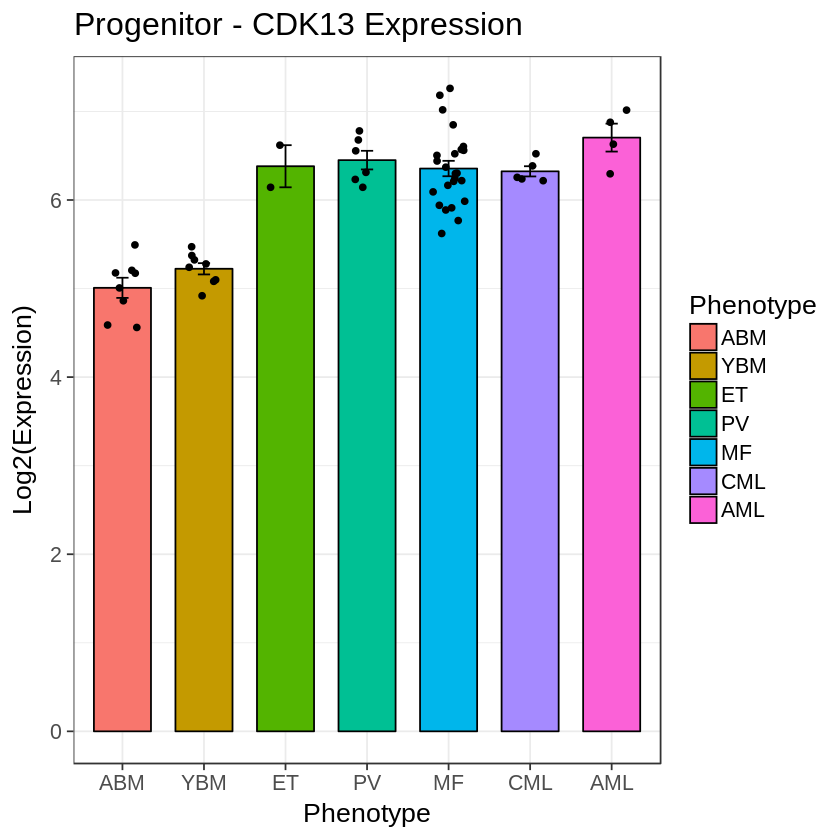

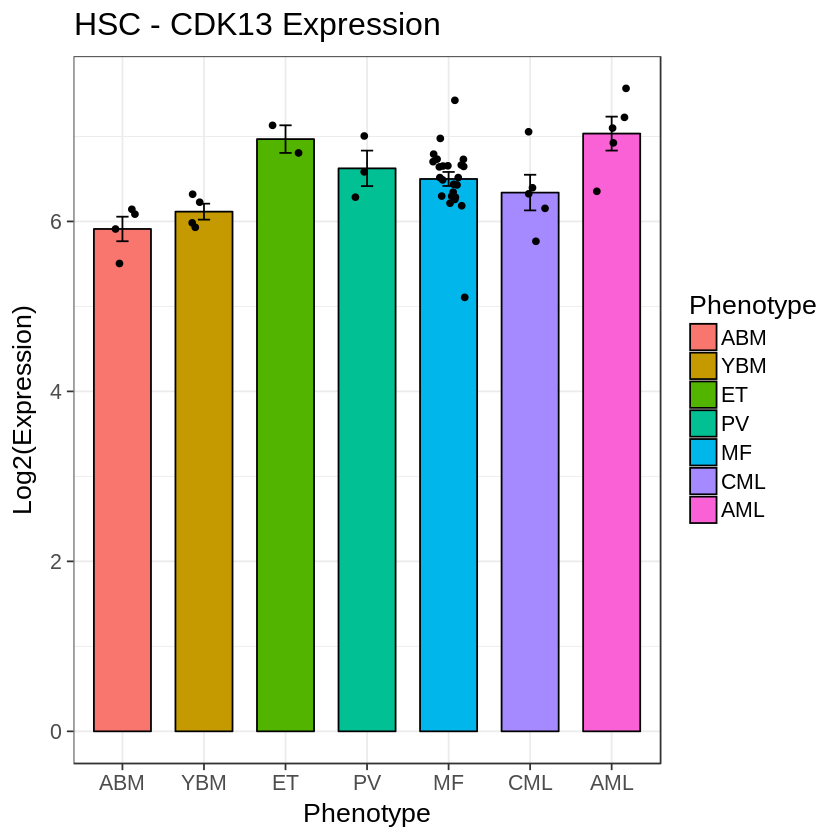

In [26]:
gene.Prog.cdk13 <- cbind(meta2.Prog.filt, CDK13=as.numeric(cpm2.Prog[gene.Prog.filt$SYMBOL %in% "CDK13"]))
gene.Stem.cdk13 <- cbind(meta2.Stem.filt, CDK13=as.numeric(cpm2.Stem[gene.Stem.filt$SYMBOL %in% "CDK13"]))
gene.Prog.cdk13.log <- cbind(meta2.Prog.filt, CDK13=as.numeric(lcpm2.Prog[gene.Prog.filt$SYMBOL %in% "CDK13"]))
gene.Stem.cdk13.log <- cbind(meta2.Stem.filt, CDK13=as.numeric(lcpm2.Stem[gene.Stem.filt$SYMBOL %in% "CDK13"]))
gene.Prog.cdk13.sum <- summarySE(data=gene.Prog.cdk13, measurevar="CDK13", groupvars=c("Phenotype"))
gene.Stem.cdk13.sum <- summarySE(data=gene.Stem.cdk13, measurevar="CDK13", groupvars=c("Phenotype"))

#pdf(file="Progenitor_CDK13_ABM_YBM_log2expressionBarplot_withjitter.pdf", width=7, height=7)
ggbarplot(gene.Prog.cdk13.log, x="Phenotype", y="CDK13", add=c("mean_se", "jitter"), fill="Phenotype") + 
    theme_bw(base_size=16) + ylab("Log2(Expression)") + labs(title="Progenitor - CDK13 Expression")
#dev.off()
#pdf(file="Stem_CDK13_ABM_YBM_log2expressionBarplot_withjitter.pdf", width=7, height=7)
ggbarplot(gene.Stem.cdk13.log, x="Phenotype", y="CDK13", add=c("mean_se", "jitter"), fill="Phenotype") + 
     theme_bw(base_size=16) + ylab("Log2(Expression)") + labs(title="HSC - CDK13 Expression")
#dev.off()


Warning message in mean.default(xx[[col]], na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in mean.default(xx[[col]], na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in mean.default(xx[[col]], na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in mean.default(xx[[col]], na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in mean.default(xx[[col]], na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in mean.default(xx[[col]], na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in mean.default(xx[[col]], na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in qt(conf.interval/2 + 0.5, datac$N - 1):
“NaNs produced”Warning message in mean.default(xx[[col]], na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in mean.default(xx[[col]], na.rm = na.

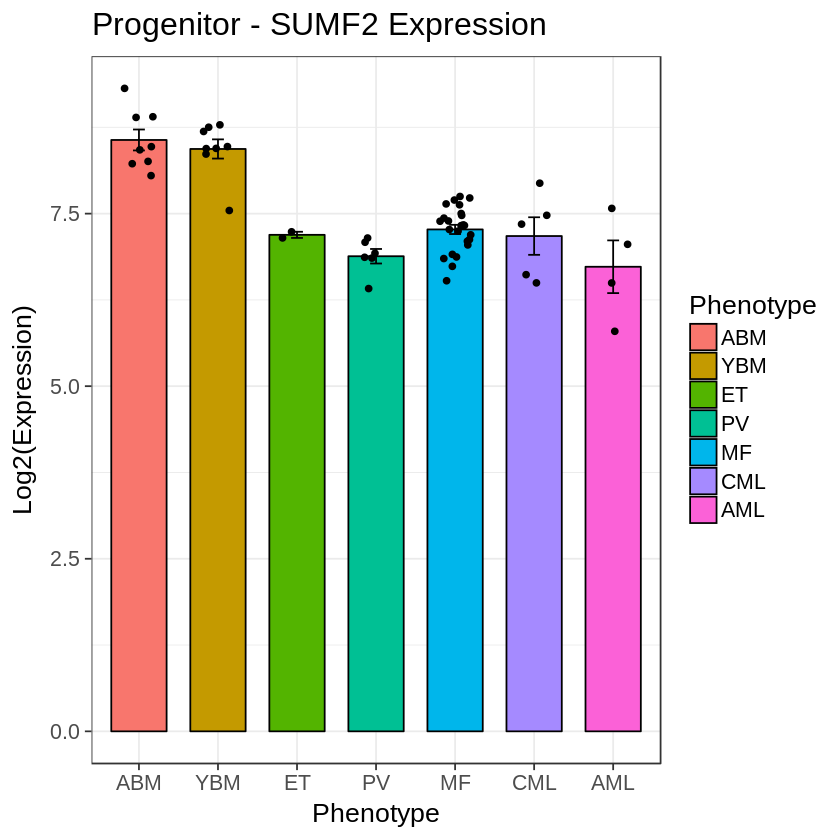

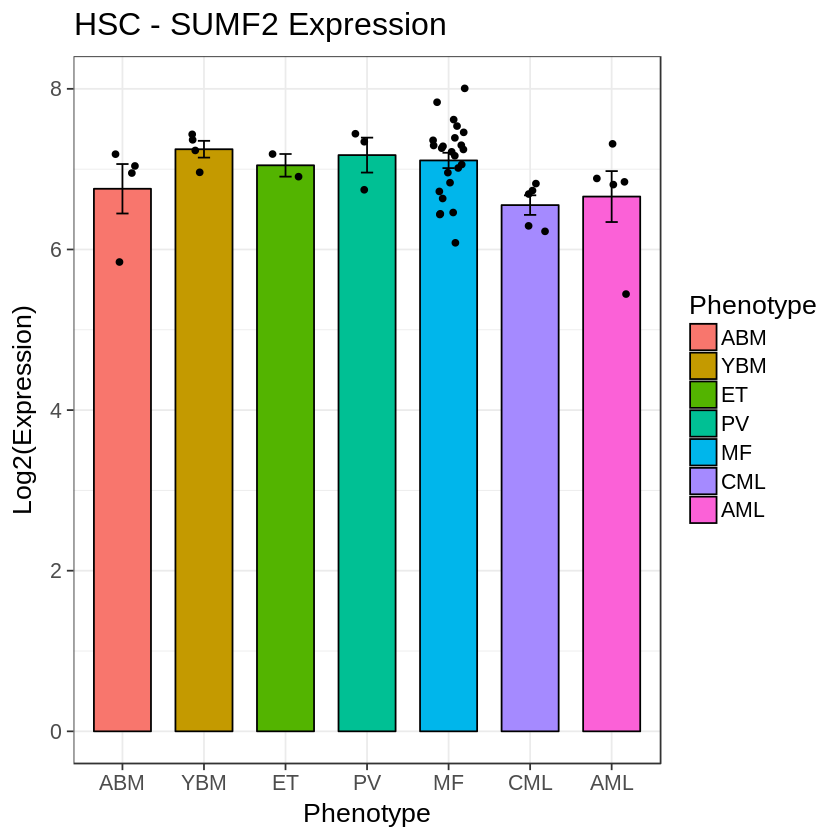

In [32]:
gene.Prog.sumf2 <- cbind(meta2.Prog.filt, sumf2=as.numeric(cpm2.Prog[gene.Prog.filt$SYMBOL %in% "SUMF2"]))
gene.Stem.sumf2 <- cbind(meta2.Stem.filt, sumf2=as.numeric(cpm2.Stem[gene.Stem.filt$SYMBOL %in% "SUMF2"]))
gene.Prog.sumf2.log <- cbind(meta2.Prog.filt, sumf2=as.numeric(lcpm2.Prog[gene.Prog.filt$SYMBOL %in% "SUMF2"]))
gene.Stem.sumf2.log <- cbind(meta2.Stem.filt, sumf2=as.numeric(lcpm2.Stem[gene.Stem.filt$SYMBOL %in% "SUMF2"]))

gene.Prog.sumf2.sum <- ddply(gene.Prog.sumf2, c("Phenotype"), summarise, 
                             N=length(sumf2), mean=mean(sumf2), sd=sd(sumf2), se = sd/sqrt(N))

gene.Prog.sumf2.sum <- summarySE(data=gene.Prog.sumf2, measurevar="SUMF2", groupvars=c("Phenotype"))
gene.Stem.sumf2.sum <- summarySE(data=gene.Stem.sumf2, measurevar="SUMF2", groupvars=c("Phenotype"))

#pdf(file="Progenitor_SUMF2_ABM_YBM_log2expressionBarplot_withjitter.pdf", width=7, height=7)
ggbarplot(gene.Prog.sumf2.log, x="Phenotype", y="sumf2", add=c("mean_se", "jitter"), fill="Phenotype") + 
    theme_bw(base_size=16) + ylab("Log2(Expression)") + labs(title="Progenitor - SUMF2 Expression")
#dev.off()
#pdf(file="Stem_sumf2_ABM_YBM_log2expressionBarplot_withjitter.pdf", width=7, height=7)
ggbarplot(gene.Stem.sumf2.log, x="Phenotype", y="sumf2", add=c("mean_se", "jitter"), fill="Phenotype") + 
    theme_bw(base_size=16) + ylab("Log2(Expression)") + labs(title="HSC - SUMF2 Expression")
#dev.off()
